# **Sentiment Analyzer for Game Communities: The Commercial Value of Understanding Public Reaction**

In today's gaming landscape, games are no longer just finished products released into the market. They have become ever-evolving services, constantly updated with bug fixes, patches, and announcements of future features. In this context, it is crucial for game companies to understand the community's reaction to these game modifications.

A sentiment analyzer for tweets generated by game communities plays a vital role in this scenario. It allows companies to monitor and analyze public opinion regarding news about tournaments, bug fixes, updates, and future patches, among other aspects. The ability to observe and interpret community responses in real-time is an invaluable asset for game companies.

The sentiment analyzer program developed focuses specifically on tweets from the Dota 2 and Counter-Strike communities. While the application can be extended to other gaming communities, it is particularly valuable to train the program using a more specific database containing terms and nuances relevant to each game.

By training the sentiment analyzer with game-specific data, it becomes more adept at accurately interpreting the sentiments expressed within these communities. It can capture the unique language, jargon, and context associated with the game, enabling more precise sentiment analysis tailored to these games.

```
PRE PROCESSING
```

In [1]:
!pip install transformers

You should consider upgrading via the 'c:\users\giova\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [3]:
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence

import torch

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Pre-processing and number convertion
def preprocess_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    processed_data = []

    for line in lines:
        # Clean text
        cleaned_text = line.strip()

        # Tokenizer
        tokens = tokenizer.tokenize(cleaned_text)

        # Conversion into numerical representations
        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # Data as tensors
        input_ids = torch.tensor(input_ids)

        # Add pre-processed at list
        processed_data.append(input_ids)

    return processed_data

In [ ]:
from torch.nn.functional import pad

# Data path
positive_file = '/content/drive/MyDrive/tweet_data/positive.txt'
negative_file = '/content/drive/MyDrive/tweet_data/negative.txt'

# Pre-processing of positive data
positive_data = preprocess_data(positive_file)

# Pre-processing of negative data
negative_data = preprocess_data(negative_file)

# Padding tensors adjustment
def pad_data(data):
    padded_data = pad_sequence(data, batch_first=True, padding_value=0)
    return padded_data

# Adjust the size of the positive_data and negative_data tensors
positive_data = pad_data(positive_data)
negative_data = pad_data(negative_data)

# Example display of pre-processed data
print("Pre-processed data example:")
print(positive_data[0])
print(negative_data[0])


Pre-processed data example:
tensor([  157, 13034, 95825, 11090,   131, 10747, 10124, 10380,   171, 29948,
        10157,   119,   146,   100,   181, 12127, 43213, 10230, 10950,   119,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
tensor([  157, 13034, 95825, 11090,   131,   146, 30181, 28870, 81160, 16070,
        14075, 10160, 62006, 14128, 10635, 26506, 10237,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])


```
BERT TRAINING
```

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define BERT model for sequence sort
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

# Define hyperparameters
batch_size = 16
lr = 2e-5
num_epochs = 10

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

```
TENSOR PADDING ADJUST
```

In [ ]:
# Verify max length between positive and negative data
max_len = max(len(positive_data[0]), len(negative_data[0]))

# Adjust tensor padding size to max_len
def pad_data_fixed_size(data, max_len):
    padded_data = pad_sequence(data, batch_first=True, padding_value=0)
    padded_data = padded_data[:, :max_len]
    padded_data = pad(padded_data, (0, max_len - padded_data.size(1)), value=0)
    return padded_data

# tensor sizes positive_data and negative_data
positive_data = pad_data_fixed_size(positive_data, max_len)
negative_data = pad_data_fixed_size(negative_data, max_len)

# Example display of pre-processed data
print("Example of pre-processed data:")
print(positive_data[0])
print(negative_data[0])

# Convert the labels to tensors
positive_labels = torch.tensor([1] * len(positive_data))
negative_labels = torch.tensor([0] * len(negative_data))

# Concatenate data and labels
all_data = torch.cat((positive_data, negative_data))
all_labels = torch.cat((positive_labels, negative_labels))

# Dataset instances
dataset = CustomDataset(all_data, all_labels)

print("Positive and Negative now have same tensor size.")


Example of pre-processed data:
tensor([  157, 13034, 95825, 11090,   131, 10747, 10124, 10380,   171, 29948,
        10157,   119,   146,   100,   181, 12127, 43213, 10230, 10950,   119,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
tensor([  157, 13034, 95825, 11090,   131,   146, 30181, 28870, 81160, 16070,
        14075, 10160, 62006, 14128, 10635, 26506, 10237,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
          

```
TRAINING, VALIDATION, TESTING
```


In [ ]:
# Split the dataset into training, validation and testing
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


In [ ]:
# Data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()

# Accuracy
def accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, dim=1)
    correct = (predicted == y_true).sum().item()
    total = y_true.size(0)
    return correct / total

In [ ]:
# Lists to store loss curves
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in train_dataloader:
        # Clear the gradients
        model.zero_grad()

        # Prepare the input data
        inputs = pad(inputs, (0, 70 - inputs.size(1)), value=0).to(torch.long)
        labels = labels.to(torch.long)

        # Get the model outputs
        outputs = model(inputs, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        # Update model parameters
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(logits, labels)

    # Calculate the average losses and training accuracy
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # Evaluation mode
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = pad(inputs, (0, 70 - inputs.size(1)), value=0).to(torch.long)
            labels = labels.to(torch.long)

            outputs = model(inputs, labels=labels)
            loss, logits = outputs.loss, outputs.logits

            val_loss += loss.item()
            val_acc += accuracy(logits, labels)

    # Calculate the average of the losses and validation accuracy
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    # Record training and validation losses
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'| Train Loss: {train_loss:.4f}  | Train Accuracy: {train_acc:.4f} |')
    print(f'| Val Loss: {val_loss:.4f}    | Val Accuracy: {val_acc:.4f}   |')
    print('-----------------------------------------------------------')


Epoch 1/10:
| Train Loss: 0.6111  | Train Accuracy: 0.6858 |
| Val Loss: 0.4793    | Val Accuracy: 0.8021   |
-----------------------------------------------------------
Epoch 2/10:
| Train Loss: 0.5711  | Train Accuracy: 0.7170 |
| Val Loss: 0.4136    | Val Accuracy: 0.8229   |
-----------------------------------------------------------
Epoch 3/10:
| Train Loss: 0.4216  | Train Accuracy: 0.8542 |
| Val Loss: 0.2798    | Val Accuracy: 0.9062   |
-----------------------------------------------------------
Epoch 4/10:
| Train Loss: 0.3309  | Train Accuracy: 0.8715 |
| Val Loss: 0.1895    | Val Accuracy: 0.9688   |
-----------------------------------------------------------
Epoch 5/10:
| Train Loss: 0.2205  | Train Accuracy: 0.9392 |
| Val Loss: 0.1655    | Val Accuracy: 0.9375   |
-----------------------------------------------------------
Epoch 6/10:
| Train Loss: 0.1542  | Train Accuracy: 0.9531 |
| Val Loss: 0.0554    | Val Accuracy: 1.0000   |
----------------------------------------



```
GRAPHS AND DATA
```



In [5]:
!pip install snscrape
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 2.0 MB/s eta 0:00:00


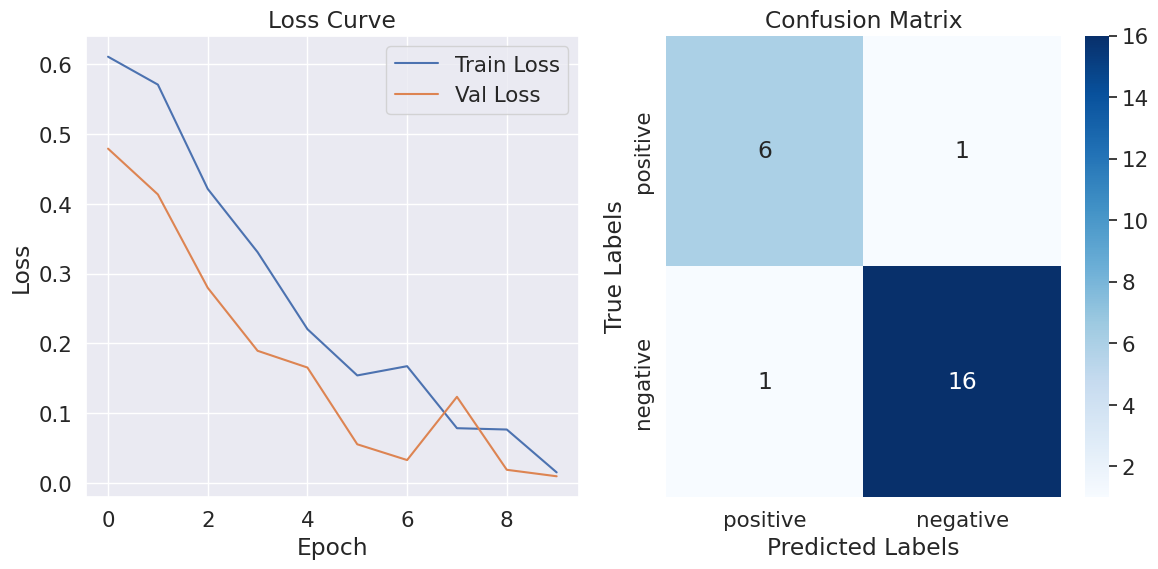

In [ ]:
# Evaluation mode in the test set
model.eval()
test_loss = 0.0
test_acc = 0.0
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = pad(inputs, (0, 70 - inputs.size(1)), value=0).to(torch.long)
        labels = labels.to(torch.long)

        outputs = model(inputs, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        test_loss += loss.item()
        test_acc += accuracy(logits, labels)

        # Store predictions and true labels for confusion and classification matrix report
        predicted_labels = torch.argmax(logits, dim=1)
        predictions.extend(predicted_labels.tolist())
        true_labels.extend(labels.tolist())

# Calc the average of losses and test accuracy
test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)

# Calc the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Labels
class_labels = ['positive', 'negative']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss curve of training and validation
axes[0].plot(train_loss_history, label='Train Loss')
axes[0].plot(val_loss_history, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss Curve')

# Plot confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axes[1])
axes[1].set_title('Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Metrics Printing
print('-----------------------------------------')
print('Test Metrics:')
print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}')
print('-----------------------------------------')

-----------------------------------------
Test Metrics:
Test Loss: 0.4729 | Test Accuracy: 0.8750
-----------------------------------------


In [ ]:
# Classification Report
classification_rep = classification_report(true_labels, predictions)

print('--------------------------------------------------------')
print('Classification Report:')
print(classification_rep)
print('--------------------------------------------------------')

--------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.94      0.94      0.94        17

    accuracy                           0.92        24
   macro avg       0.90      0.90      0.90        24
weighted avg       0.92      0.92      0.92        24

--------------------------------------------------------




```
SAVE MODEL
```



In [ ]:
# Save model
model_path = "/content/drive/MyDrive/sentiment-analysis/model"
tokenizer_path = "/content/drive/MyDrive/sentiment-analysis/tokenizer"

model.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)


('/content/drive/MyDrive/sentiment-analysis/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/sentiment-analysis/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/sentiment-analysis/tokenizer/vocab.txt',
 '/content/drive/MyDrive/sentiment-analysis/tokenizer/added_tokens.json')

```
EXCTRATION TWITTER
```

In [ ]:
!pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git

  Cloning https://github.com/JustAnotherArchivist/snscrape.git to /tmp/pip-req-build-vau04xp9
  Running command git clone --filter=blob:none --quiet https://github.com/JustAnotherArchivist/snscrape.git /tmp/pip-req-build-vau04xp9
  Resolved https://github.com/JustAnotherArchivist/snscrape.git to commit 614d4c2029a62d348ca56598f87c425966aaec66
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
import snscrape.modules.twitter as sns
from torch.nn.functional import softmax
import re

In [8]:
model_path = "/content/drive/MyDrive/sentiment-analysis/model"
tokenizer_path = "/content/drive/MyDrive/sentiment-analysis/tokenizer"

tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

``` 
TWEET SIMULATOR, TAKE AN USER INPUT AND DOES THE SENTIMENT ANALYSIS BASED ON TRAINED MODEL
```

In [22]:
import torch
import torch.nn.functional as F

tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

def preprocess_text(text):
    # Remove special characters
    text = re.sub(r"[^\w\s]", "", text)
    return text

# Get user input
print("------------------------------")
user_input = input("TWEET: ")

# Pre-process input text
processed_text = preprocess_text(user_input)

# Tokenize input
tokens = tokenizer.encode_plus(
    processed_text,
    max_length=128,
    truncation=True,
    padding="max_length",
    add_special_tokens=True,
    return_tensors="pt"
)

# Input models
input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]

# Inference using the model
outputs = model(input_ids, attention_mask=attention_mask)
logits = outputs.logits
probabilities = F.softmax(logits, dim=1)

# Get sentiment class (0 for negative, 1 for positive)
predicted_class = torch.argmax(probabilities).item()

# Classify sentiment
print(" ")

if predicted_class == 0:
    print("SENTIMENT: NEGATIVE")
else:
    print("SENTIMENT: POSITIVE")

print("------------------------------")

------------------------------
TWEET: should fix these bugs and hire more graphics designers
 
SENTIMENT: NEGATIVE
------------------------------




```
TWEET URL TO ANALYSE WITH SNSCRAPE
DUE TO TWITTER'S NEW POLICY REGARDING BLOCKING OF SCRAPING 2023-06-30, THIS CODE AREA DOESN'T WORK ANYMORE.

TAKES A TWITTER URL, EXTRACTS ID, SEARCH FOR TWEETS, PREPROCESS TEXT,
FEEDS IT INTO TRAINED MODEL AND PREDICTS THE SENTIMENT OF EACH TWEET.

```



In [ ]:
# INSERT HERE TWITTER URL
tweet_url = "https://twitter.com/..." # Insert here your URL

# Extract tweet ID
def extract_tweet_id(url):
    return url.split("/")[-1]

tweet_id = extract_tweet_id(tweet_url)

# Build query search
query = f"url:{tweet_id} lang:en"

# Searching
tweets = list(sns.TwitterSearchScraper(query).get_items())

def preprocess_text(text):
    # Remove special characters
    text = re.sub(r"[^\w\s]", "", text)
    return text

# Show tweets
for tweet in tweets:
    print("------------------------------")
    #print("USER: @",tweet.username)
    print("TWEET: ",tweet.content)

    # Pre-process tweet text
    processed_text = preprocess_text(tweet.content)

    # Tokenizer
    tokens = tokenizer.encode_plus(
        processed_text,
        max_length=128,
        truncation=True,
        padding="max_length",
        add_special_tokens=True,
        return_tensors="pt"
    )

    # Input models
    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    # Inference using model
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = softmax(logits, dim=1)

    # Get class (0 negative - 1 positive)
    predicted_class = torch.argmax(probabilities).item()

    # Class show
    if predicted_class == 0:
        print("CLASSIFICATION: Negative")
    else:
        print("CLASSIFICATION: Positive")

```
GET TWEETS FROM WEB, FUNCTION USED TO COLLECT DATA FOR TRAINING SET DATABASE
```

In [ ]:
# GET URL
tweet_url = "https://twitter.com/..." # Insert here your URL

# Extract ID
def extract_tweet_id(url):
    return url.split("/")[-1]

tweet_id = extract_tweet_id(tweet_url)

# Build query
query = f"url:{tweet_id} lang:en"

# Search
tweets = list(sns.TwitterSearchScraper(query).get_items())

def preprocess_text(text):
    # Remove special characters
    text = re.sub(r"[^\w\s]", "", text)
    return text

# Show tweets
for tweet in tweets:
    print("==================================")
    #print("USER: @",tweet.username)
    print("TWEET: ",tweet.content)